## Named Entity Recognition — Cluster Characters

In [ ]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install python-Levenshtein

In [1]:
import spacy

In [2]:
from collections import Counter

In [3]:
import pandas as pd

In [4]:
import itertools

In [5]:
import networkx 
from networkx.algorithms.components.connected import connected_components, node_connected_component

In [6]:
import itertools
from fuzzywuzzy import fuzz

In [7]:
import glob
from pathlib import Path

In [8]:
pd.set_option("max_rows", 400)

In [9]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [10]:
#nlp = spacy.load('en_core_web_sm')

In [11]:
filepath = "../texts/literature/Jones-Lost-in-The-City.txt"

In [13]:
text = open(filepath).read()

In [14]:
document = nlp(text)

In [33]:
displacy.render(document, style="ent")

## Get People (More Accurately)

Sometimes spaCy will correctly tag a person as a "PERSON" but then later tag the same person as a different entity as an organization ("ORG") or a place ("GPE").

So, to get a more accurate character count, we're going to extract all the named entities that spaCy identified as a "PERSON" and then count *any* instance of that entitiy, regardless of its NER label.

Extract list of all named entities labeled "PERSON":

In [171]:
spacy_identified_people = []

for named_entity in document.ents:
    if named_entity.label_ == "PERSON":
        
        spacy_identified_people.append(named_entity.text)

Output list of identified to a CSV file and manually edit by hand

In [172]:
pd.DataFrame(Counter(spacy_identified_people).most_common(), columns=['character', 'count']).to_csv('spacy-identified-people.csv', index=False)

Re-upload CSV file for accurate list of people

In [15]:
spacy_identified_people = pd.read_csv('spacy-identified-people.csv')['character'].tolist()

In [16]:
all_people_matches = []
all_people_matches_plus_ids = []

#Get all entity matches for a previously identified person
for named_entity in document.ents:
    if named_entity.text in spacy_identified_people:
        person = named_entity.text
        
        #Remove apostrophe s
        person = person.replace("’s", "").strip()
        person_index = named_entity.start_char
        
        all_people_matches.append(person)
        all_people_matches_plus_ids.append([person, person_index])

In [17]:
people_tally = Counter(all_people_matches)
character_df = pd.DataFrame(people_tally.most_common())
character_df.columns = ['character', 'count']

character_df

,character,count
0,Cassandra,113
1,Anita,90
2,Joyce,90
3,Caesar,74
4,Madeleine,69
5,Vivian,67
6,Melanie,65
7,Rickey,62
8,Sherman,60
9,Maddie,58


## Cluster By Name and Distance


spaCy doesn't know that "Betsy Ann Morgan" and "Betsy Ann" should be the same person. So we're also going to pair two character names if they're an extremely close match and they occur within 800 characters of one another.

In [202]:
from datetime import datetime
startTime = datetime.now()

aggregated_people = []

threshold_distance = 750

#Get all entity matches for a previously identified person
for person, person_index in all_people_matches_plus_ids:
    for another_person, another_person_index in all_people_matches_plus_ids:
        distance = abs(person_index - another_person_index)
        if distance < threshold_distance:
            
            if person != another_person:
                
                if fuzz.partial_ratio(person, another_person) == 100:
                    aggregated_people.append((person, another_person))
                    
print(datetime.now() - startTime)

0:00:02.834621


With itertools (slightly faster)

In [200]:
from datetime import datetime
startTime = datetime.now()

aggregated_people = []

threshold_distance = 750

#Get all entity matches for a previously identified person
for person, another_person in itertools.combinations(all_people_matches_plus_ids, 2):
        distance = abs(person[1] - another_person[1])
        if distance < threshold_distance:
            
            if person[0] != another_person[0]:
                
                if fuzz.partial_ratio(person[0], another_person[0]) == 100:
                    aggregated_people.append((person[0], another_person[0]))
                    
print(datetime.now() - startTime)

0:00:01.610970


## Make a network!

In [277]:
from datetime import datetime
startTime = datetime.now()

edge_list = []

threshold_distance = 400

#Get all entity matches for a previously identified person
for person, another_person in itertools.combinations(all_people_matches_plus_ids, 2):
        distance = abs(person[1] - another_person[1])
        if distance < threshold_distance:
            
            if person[0] != another_person[0]:
                
                edge_list.append((person[0], another_person[0]))
                    
print(datetime.now() - startTime)

0:00:00.946120


In [278]:
character_df = pd.DataFrame(Counter(edge_list).most_common(), columns=['character_pair', 'edge_weight'])
character_df['character1']=character_df['character_pair'].str[0]
character_df['character2']=character_df['character_pair'].str[1]

In [279]:
character_df

,character_pair,edge_weight,character1,character2
0,"(Cassandra, Anita)",111,Cassandra,Anita
1,"(Melanie, Cassandra)",100,Melanie,Cassandra
2,"(Anita, Cassandra)",88,Anita,Cassandra
3,"(Cassandra, Melanie)",78,Cassandra,Melanie
4,"(Melanie, Anita)",64,Melanie,Anita
...,...,...,...,...
1552,"(Vernelle, George Carter)",1,Vernelle,George Carter
1553,"(Vernelle Wise, George Carter)",1,Vernelle Wise,George Carter
1554,"(Marie, George Carter)",1,Marie,George Carter
1555,"(Marie heard Vernelle, Vernelle)",1,Marie heard Vernelle,Vernelle


In [287]:
got_df = pd.read_csv('../data/got-edges.csv')

In [290]:
G=networkx.from_pandas_edgelist(got_df, 'Source', 'Target', 'Weight')
#G.add_weighted_edges_from(character_df)

In [281]:
G=networkx.from_pandas_edgelist(character_df, 'character1', 'character2', 'edge_weight')
#G.add_weighted_edges_from(character_df)

In [96]:
import matplotlib.pyplot as plt

In [271]:
networkx.write_graphml(G, 'lost-in-the-city-character-network.graphml', encoding='utf-8')

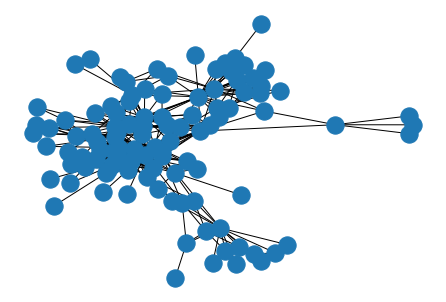

In [291]:
networkx.draw(G, with_labels=False, font_weight='bold')

In [216]:
import networkx as nx

from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

# Prepare Data
G = nx.karate_club_graph()

SAME_CLUB_COLOR, DIFFERENT_CLUB_COLOR = "black", "red"
edge_attrs = {}

for start_node, end_node, _ in G.edges(data=True):
    edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["club"] == G.nodes[end_node]["club"] else DIFFERENT_CLUB_COLOR
    edge_attrs[(start_node, end_node)] = edge_color

nx.set_edge_attributes(G, edge_attrs, "edge_color")

# Show with Bokeh
plot = Plot(plot_width=400, plot_height=400,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Graph Interaction Demonstration"

node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("club", "@club")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

show(plot)

In [220]:
G=networkx.from_pandas_edgelist(character_df, 'character1', 'character2', 'edge_weight')


In [230]:
import bokeh.io
# this is here only for completeness to clarify where
# the methods are nested (you probably already imported this earlier)


bokeh.io.reset_output()
bokeh.io.output_notebook()

Loading BokehJS ...

In [293]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='node_size', values=degrees)

In [304]:
from bokeh.plotting import figure

HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Degree", "@node_size")
]

plot = figure(plot_width=500, plot_height=500, tooltips = HOVER_TOOLTIPS, tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-5.1, 5.1), y_range=Range1d(-5.1, 5.1), title='Game of Thrones Network')

#node_hover_tool = HoverTool(tooltips=[])

#plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, networkx.spring_layout, scale=5, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size='node_size', fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=1)

plot.renderers.append(graph_renderer)
plot.xgrid.visible = False
plot.ygrid.visible = False
show(plot)

## Circle Graph

In [326]:
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Degree", "@node_size")
]

plot = figure(plot_width=500, plot_height=500, tooltips = HOVER_TOOLTIPS, tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
            x_range=Range1d(-5.1, 5.1), y_range=Range1d(-5.1, 5.1), title='Game of Thrones Network')

graph_renderer = from_networkx(G, networkx.circular_layout, scale=10, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=10, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=10, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=10, fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=1)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=1)

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)
plot.xgrid.visible = False
plot.ygrid.visible = False
show(plot)


In [420]:
graph_renderer.node_renderer.data_source

ColumnDataSource(id='91828', ...)

In [450]:
graph_renderer.layout_provider.graph_layout.items()

dict_items([('Aemon', array([-1.42264582,  0.36310159])), ('Grenn', array([-2.61475094,  0.08605906])), ('Samwell', array([-2.27511628, -0.24032029])), ('Aerys', array([1.0933525, 0.2640564])), ('Jaime', array([ 0.76717875, -0.72423991])), ('Robert', array([0.40407974, 0.37585865])), ('Tyrion', array([ 1.08869016, -0.40277452])), ('Tywin', array([ 0.71491959, -0.56922657])), ('Alliser', array([-2.6721342 , -0.30554347])), ('Mance', array([-2.547448  ,  0.35436394])), ('Amory', array([ 4.03802909, -0.10707528])), ('Oberyn', array([ 2.30969973, -0.3325769 ])), ('Arya', array([ 0.15104887, -1.29623973])), ('Anguy', array([ 0.63770003, -3.0098028 ])), ('Beric', array([ 0.58677945, -2.16864064])), ('Bran', array([-1.42115757, -1.43865295])), ('Brynden', array([ 0.04957062, -2.13405342])), ('Cersei', array([ 1.0478933, -0.6967616])), ('Gendry', array([ 0.99237322, -2.34220908])), ('Gregor', array([ 1.43566746, -0.79890327])), ('Joffrey', array([ 0.9651381 , -0.90139208])), ('Jon', array([-1.

In [445]:
names = []
x_coordinates = []
y_coordinates = []

for name, x_y_coords in graph_renderer.layout_provider.graph_layout.items():
    names.append(name)
    x_coordinates.append(x_y_coords[0])
    y_coordinates.append(x_y_coords[1])

label_map = dict(zip(names, [x_coordinates, y_coordinates]))

In [451]:
G.nodes()

NodeView(('Aemon', 'Grenn', 'Samwell', 'Aerys', 'Jaime', 'Robert', 'Tyrion', 'Tywin', 'Alliser', 'Mance', 'Amory', 'Oberyn', 'Arya', 'Anguy', 'Beric', 'Bran', 'Brynden', 'Cersei', 'Gendry', 'Gregor', 'Joffrey', 'Jon', 'Rickon', 'Roose', 'Sandor', 'Thoros', 'Balon', 'Loras', 'Belwas', 'Barristan', 'Illyrio', 'Hodor', 'Jojen', 'Luwin', 'Meera', 'Nan', 'Theon', 'Brienne', 'Bronn', 'Podrick', 'Lothar', 'Walder', 'Catelyn', 'Edmure', 'Hoster', 'Jeyne', 'Lysa', 'Petyr', 'Robb', 'Roslin', 'Sansa', 'Stannis', 'Elia', 'Ilyn', 'Meryn', 'Pycelle', 'Shae', 'Varys', 'Craster', 'Karl', 'Daario', 'Drogo', 'Irri', 'Daenerys', 'Aegon', 'Jorah', 'Kraznys', 'Missandei', 'Rakharo', 'Rhaegar', 'Viserys', 'Worm', 'Davos', 'Cressen', 'Salladhor', 'Eddard', 'Eddison', 'Gilly', 'Qyburn', 'Renly', 'Tommen', 'Janos', 'Bowen', 'Kevan', 'Margaery', 'Myrcella', 'Dalla', 'Melisandre', 'Orell', 'Qhorin', 'Rattleshirt', 'Styr', 'Val', 'Ygritte', 'Jon Arryn', 'Lancel', 'Olenna', 'Marillion', 'Robert Arryn', 'Ellaria', 

In [405]:
source = ColumnDataSource(data=graph_renderer.layout_provider.graph_layout)

In [410]:
source[0]

TypeError: 'ColumnDataSource' object is not subscriptable

In [ ]:
LabelSet(x='x', y='y', text='names', level='glyph',
         x_offset=5, y_offset=5, source=source)

In [ ]:
values()

In [369]:
type(graph_renderer.layout_provider.graph_layout)

bokeh.core.property.wrappers.PropertyValueDict

array([2.10905355, 1.46841813])

In [ ]:
x, y = zip(*graph.layout_provider.graph_layout.values())

In [352]:
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
from bokeh.models import CustomJSTransform, LabelSet

HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Degree", "@node_size")
]

plot = figure(plot_width=500, plot_height=500, tooltips = HOVER_TOOLTIPS, tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
            x_range=Range1d(-5.1, 5.1), y_range=Range1d(-5.1, 5.1), title='Game of Thrones Network')

graph_renderer = from_networkx(G, networkx.spring_layout, scale=5, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size='node_size', fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size='node_size', fill_color='green')
graph_renderer.node_renderer.hover_glyph = Circle(size='node_size', fill_color='red')

graph_renderer.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color='green', line_width=1)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color='red', line_width=1)


graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = NodesAndLinkedEdges()



plot.renderers.append(graph_renderer)
plot.xgrid.visible = False
plot.ygrid.visible = False



from bokeh.transform import transform    

# add the labels to the node renderer data source
source = graph_renderer.node_renderer.data_source
source.data['names'] = [str(x) for x in source.data['index']]

# create a transform that can extract the actual x,y positions
code = """
    var result = new Float64Array(xs.length)
    for (var i = 0; i < xs.length; i++) {
        result[i] = provider.graph_layout[xs[i]][%s]
    }
    return result
"""
xcoord = CustomJSTransform(v_func=code % "0", args=dict(provider=graph_renderer.layout_provider))
ycoord = CustomJSTransform(v_func=code % "1", args=dict(provider=graph_renderer.layout_provider))

# Use the transforms to supply coords to a LabelSet 
labels = LabelSet(x=transform('index', xcoord),
                  y=transform('index', ycoord),
                  text='names', text_font_size="12px",
                  x_offset=5, y_offset=5,
                  source=source, render_mode='canvas')

plot.add_layout(labels)
show(plot)


In [224]:
plot = Plot(plot_width=1000, plot_height=1000,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))

node_hover_tool = HoverTool(tooltips=[("", "@index")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, networkx.spring_layout, scale=2, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

show(plot)

In [ ]:
!pip install visJS2jupyter

In [ ]:
!pip install py2cytoscape

In [24]:
import visJS2jupyter.visJS_module

In [199]:
nodes = G.nodes()
edges = list(G.edges())

In [190]:
nodes_dict = [{"id":n, "x":pos[n][0]*300, "y":pos[n][1]*300} for n in nodes]
node_map = dict(zip(nodes,range(len(nodes))))  # map to indices for source/target in edges

In [189]:
for i in range(len(edges)):
    print(node_map[edges][i][0])
    #"source":node_map[edges[i][0]], "target":node_map[edges[i][1]]} 

TypeError: unhashable type: 'dict'

In [25]:
nodes = list(G.nodes()) # must cast to list to maintain compatibility between nx 1.11 and 2.0
edges = list(G.edges())

In [286]:
!pip show bokeh

Name: bokeh
Version: 2.0.2
Summary: Interactive plots and applications in the browser from Python
Home-page: http://github.com/bokeh/bokeh
Author: Bokeh Team
Author-email: info@bokeh.org
License: BSD-3-Clause
Location: /Users/melaniewalsh/opt/anaconda3/lib/python3.7/site-packages
Requires: tornado, typing-extensions, pillow, Jinja2, python-dateutil, packaging, numpy, PyYAML
Required-by: 


In [34]:
from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx
from bokeh.io import output_notebook, show

In [35]:
output_notebook()

Loading BokehJS ...

In [ ]:
!pip install pygraphviz

In [100]:
degrees = [degree for node, degree in networkx.degree(G)]

In [105]:
degrees = networkx.degree(G)

In [156]:
G.get_node_attributes()

AttributeError: 'Graph' object has no attribute 'get_node_attributes'

In [155]:
networkx.info(G)

'Name: \nType: Graph\nNumber of nodes: 362\nNumber of edges: 1479\nAverage degree:   8.1713'

In [116]:
from bokeh.models import ColumnDataSource

In [126]:
node_size = {k:5*v for k,v in G.degree()} 

In [146]:
degree = networkx.degree(G)
networkx.set_node_attributes(G,  degree, 'degree')

In [166]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='node_size', values=degrees)

In [170]:
pd.DataFrame.from_dict({k:v for k,v in G.nodes(data=True)}, orient='index')

,degree,node_size
Cassandra,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",43
Anita,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",58
Melanie,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",30
Caesar,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",21
Sherman,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",15
Diane,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",37
Vivian,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",41
Rhonda,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",17
Manny,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",15
Joyce,"((Cassandra, 43), (Anita, 58), (Melanie, 30), ...",35


In [ ]:
node_source = ColumnDataSource(pd.DataFrame.from_dict({k:v for k,v in G.nodes(data=True)}, orient='index'))

plot = Plot(plot_width=400, plot_height=400,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))

graph_renderer = from_networkx(G, networkx.spring_layout, scale=10, center=(0,0))

#style
graph_renderer.node_renderer.data_source = node_source
graph_renderer.node_renderer.glyph = Circle(fill_color = 'blue',size = 'node_size' , line_color = None)

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=2)


plot.renderers.append(graph_renderer)

show(plot)

In [114]:
# Prepare Data
#G = nx.karate_club_graph()

#SAME_CLUB_COLOR, DIFFERENT_CLUB_COLOR = "black", "red"
#edge_attrs = {}

# for start_node, end_node, _ in G.edges(data=True):
#     edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["club"] == G.nodes[end_node]["club"] else DIFFERENT_CLUB_COLOR
#     edge_attrs[(start_node, end_node)] = edge_color

# nx.set_edge_attributes(G, edge_attrs, "edge_color")

# Show with Bokeh
plot = Plot(plot_width=1000, plot_height=1000,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))

#plot.title.text = "Lost in the City Characters"

node_hover_tool = HoverTool(tooltips=[("", "@index")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
#graph_renderer.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

#output_file("interactive_graphs.html")
show(plot)

TypeError: 'NoneType' object is not callable

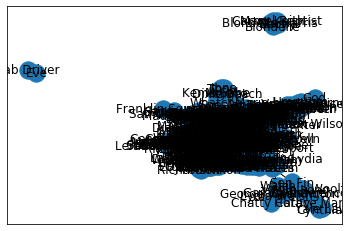

In [62]:
fig = networkx.draw_networkx(G)
fig(figsize=(20,10))

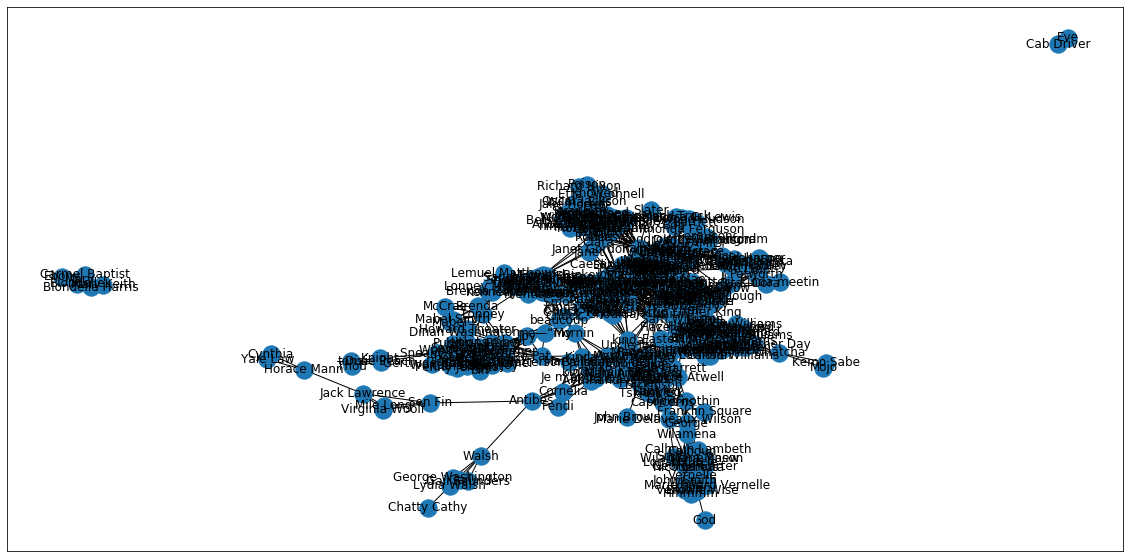

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10));
networkx.draw_networkx(G, ax=ax, with_labels=True)

In [73]:
import json

In [74]:
nodes = [{'name': str(i)}
         for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]}
         for u in G.edges()]
with open('graph.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)

<div id="d3-example"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

With the aggregated character names, we're going to use the Python library networkX to create a cluster of character names.

In [203]:
G=networkx.Graph()
G.add_edges_from(aggregated_people)
people_clusters  = list(connected_components(G))
people_clusters = [sorted(cluster, key=len, reverse=True) for cluster in people_clusters]
people_clusters

[['Betsy Ann Morgan', 'Betsy Ann'],
 ['Miles Patterson', 'Miles'],
 ['Walter Creed', 'Creed'],
 ['Jenny Creed', 'Jenny'],
 ['Robert Morgan', 'Robert'],
 ['Janet Gordon', 'Janet'],
 ['Ralph Holley', 'Ralph'],
 ['LaDeidre Gordon', 'LaDeidre'],
 ['Thelma Holley', 'Thelma'],
 ['Darlene Greenley', 'Darlene'],
 ['Etta O’Connell', 'Etta'],
 ['Mary Keith', 'Mary'],
 ['Blondelle Harris', 'Blondelle'],
 ['Cassandra G. Lewis', 'Cassandra'],
 ['Rhonda Ferguson', 'Rhonda'],
 ['Melanie Cartwright', 'Melanie'],
 ['Anita Hughes', 'Anita'],
 ['Gladys Harper', 'Gladys', 'Glady'],
 ['Joyce Moses', 'Mama Joyce', 'Joyce'],
 ['Pearl Guthrie', 'Pearl Malone', 'Pearl'],
 ['Manny Soto', 'Manny'],
 ['Sherman Wheeler', 'Sherman'],
 ['Sandra Wallington', 'Sandra'],
 ['Angelo Billings', 'Angelo'],
 ['Burberry Carol', 'Carol'],
 ['Lonney McCrae', 'Lonney'],
 ['Brenda Roper', 'Brenda'],
 ['Mabel Smith', 'Mabel'],
 ['Penny Jenkins', 'Jenkins'],
 ['Al Jenkins', 'Al'],
 ['Joy Lambert', 'Joy'],
 ['handcuff Penny', 'Penn

In [183]:
def add_clustered_characters(row):
    character = row['character']
    for cluster in people_clusters:
        if character in cluster:
            return cluster

In [184]:
def clean_and_unpack_cluster(row):
    if row['clustered_characters'] == None:
        cluster = row['character']
    else:
        cluster = " // ".join(row['clustered_characters'])
    return cluster

In [185]:
character_df['clustered_characters'] = character_df.apply(add_clustered_characters, axis=1)

In [186]:
character_df['clustered_characters'] = character_df.apply(clean_and_unpack_cluster, axis=1)

In [187]:
character_df

,character,count,clustered_characters
0,Cassandra,113,Cassandra G. Lewis // Cassandra
1,Anita,90,Anita Hughes // Anita
2,Joyce,90,Joyce Moses // Mama Joyce // Joyce
3,Caesar,74,Caesar
4,Madeleine,69,Madeleine
5,Vivian,67,Vivian // Vi
6,Melanie,65,Melanie Cartwright // Melanie
7,Rickey,62,Rickey Madison // Rickey
8,Sherman,60,Sherman Wheeler // Sherman
9,Maddie,58,Maddie Williams // Aunt Maddie // Maddie


Manually edit

In [ ]:
#character_df.sort_values(by=['clustered_characters', 'count']).to_csv('clustered_characters_draft.csv')

In [ ]:
#character_df = pd.read_csv('clustered_characters_edited.csv')

In [76]:
character_df.groupby('clustered_characters')[['count']].sum().sort_values(by='count', ascending=False).reset_index()

,clustered_characters,count
0,Cassandra G. Lewis // Cassandra,114
1,Joyce Moses // Mama Joyce // Joyce,96
2,Anita Hughes // Anita,92
3,Marie Delaveaux Wilson // Marie heard Vernelle...,77
4,Vivian // Vi,75
5,Samuel Lamont Williams // Samuel Williams // S...,75
6,Caesar,74
7,Madeleine,69
8,Melanie Cartwright // Melanie,66
9,Rickey Madison // Rickey,64


## Cluster By Name

In [52]:
from fuzzywuzzy import process

In [133]:
def cluster_characters(row):
    possibilities = process.extract(row['character'], character_df['character'].unique(), scorer=fuzz.partial_ratio)
    possibilities = [possible[0] for possible in possibilities if possible[1] == 100]
    possibilities = [combo for combo in itertools.combinations(possibilities, 2)]
    return possibilities

In [134]:
clustered_by_named = character_df.apply(cluster_characters, axis=1)

In [132]:
G=networkx.Graph()
G.add_edges_from(clustered_by_named)
people_clusters  = list(connected_components(G))
people_clusters = [sorted(cluster, key=len, reverse=True) for cluster in people_clusters]
people_clusters

[['Kinda', 'kinda']]

In [70]:
def add_clustered_characters(row):
    character = row['character']
    for cluster in people_clusters:
        if character in cluster:
            return cluster

In [73]:
def clean_and_unpack_cluster(row):
    if row['clustered_characters'] == None:
        cluster = row['character']
    else:
        cluster = " // ".join(row['clustered_characters'])
    return cluster

In [71]:
character_df['clustered_characters'] = character_df.apply(add_clustered_characters, axis=1)

In [74]:
character_df['clustered_characters'] = character_df.apply(clean_and_unpack_cluster, axis=1)

In [66]:
character_df

,character,count,clustered_characters
0,Cassandra,113,"[Cassandra, Sandra, Cassandra G. Lewis]"
1,Anita,90,"[Anita, Anita Hughes]"
2,Joyce,90,"[Joyce, Joyce Moses, Joy, Mama Joyce]"
3,Caesar,74,"[Caesar, Caesar Matthews]"
4,Madeleine,69,"[Madeleine, Madeleine Williams]"
5,Vivian,67,"[Vivian, Vi, Vivian L. Slater]"
6,Melanie,65,"[Melanie, Lani, Melanie Cartwright]"
7,Rickey,62,"[Rickey, Rickey Madison]"
8,Sherman,60,"[Sherman, Sherman Wheeler]"
9,Maddie,58,"[Maddie, Aunt Maddie, Maddie Williams]"
